# Chapter 9: Project 2: Linear Regression

In [37]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import scipy          
# Importing Linear Regression
from sklearn.linear_model import LinearRegression 
# PyMC3 for Bayesian Inference
import pymc3 as pm

In [39]:
exercise = pd.read_csv('exercise.csv')    # give path of the dataset files
calories = pd.read_csv('calories.csv')
df = pd.merge(exercise, calories, on = 'User_ID')
df = df[df['Calories'] < 300]
df = df.reset_index()
df['Intercept'] = 1
df.head(10)


,index,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Intercept
0,0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0,1
1,1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0,1
2,2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0,1
3,3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0,1
4,4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0,1
5,5,15130815,female,36,151.0,50.0,23.0,96.0,40.7,123.0,1
6,6,19602372,female,33,158.0,56.0,22.0,95.0,40.5,112.0,1
7,7,11117088,male,41,175.0,85.0,25.0,100.0,40.7,143.0,1
8,8,12132339,male,60,186.0,94.0,21.0,97.0,40.4,134.0,1
9,9,17964668,female,26,146.0,51.0,16.0,90.0,40.2,72.0,1


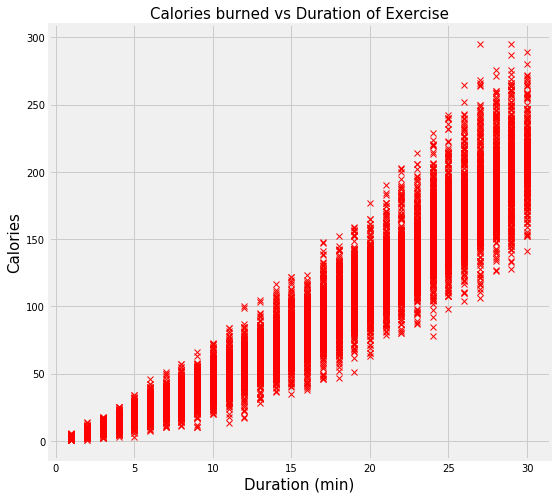

In [40]:
#plt.rcParams['axes.facecolor'] = 'white'
plt.figure(figsize=(8, 8))

plt.plot(df['Duration'], df['Calories'], 'rx');
plt.xlabel('Duration (min)', size = 15); plt.ylabel('Calories', size = 15); 
plt.title('Calories burned vs Duration of Exercise', size = 15);

In [41]:
# Create the features and response
X = df.loc[:, ['Intercept', 'Duration']]
y = df.loc[:, 'Calories']
X.head(8)


,Intercept,Duration
0,1,29.0
1,1,14.0
2,1,5.0
3,1,13.0
4,1,10.0
5,1,23.0
6,1,22.0
7,1,25.0


In [59]:
y.head(8)

0    231.0
1     66.0
2     26.0
3     71.0
4     35.0
5    123.0
6    112.0
7    143.0
Name: Calories, dtype: float64

In [74]:
y

0        231.0
1         66.0
2         26.0
3         71.0
4         35.0
         ...  
14993     45.0
14994     23.0
14995     75.0
14996     11.0
14997     98.0
Name: Calories, Length: 14998, dtype: float64

## Ordinary Least squares linear regression by hand

In [42]:
def linear_regression(X,y):
  # _coeffs = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T, X)), X.T), y)
    _coeffs = np.matmul(np.matmul(          np.linalg.inv(X.T.dot(X)) , X.T), y)
    return _coeffs

In [43]:
# Ordinary Least Squares calculations  
ols_coefs = np.matmul(np.matmul(          np.linalg.inv(X.T.dot(X)) , X.T), y)
print(f'Intercept calculated: {ols_coefs[0]}')
print(f'Slope calculated: {ols_coefs[1]}')

Intercept calculated: -21.828102526050735
Slope calculated: 7.16978334958786


Text(0.5, 1.0, 'Calories burned vs Duration of Exercise')

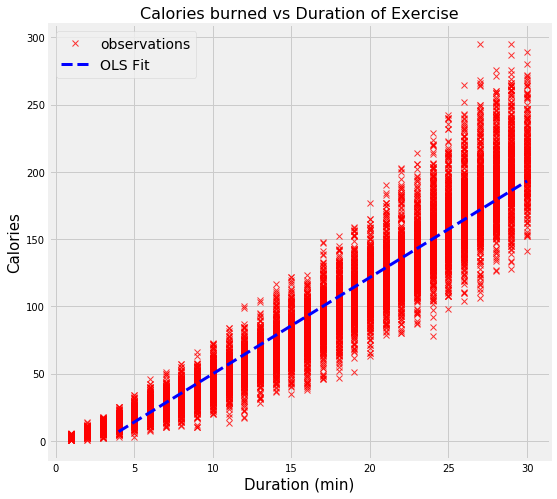

In [44]:
xs = np.linspace(4, 30, 1000)
ys = ols_coefs[0] + ols_coefs[1] * xs

plt.figure(figsize=(8, 8))

plt.plot(df['Duration'], df['Calories'], 'rx',label = 'observations', alpha = 0.8)
plt.xlabel('Duration (min)', size = 15); plt.ylabel('Calories', size = 15)
plt.plot(xs, ys, 'b--', label = 'OLS Fit', linewidth = 3)
plt.legend(prop={'size': 14})
plt.title('Calories burned vs Duration of Exercise', size = 16)

In [46]:
#specifying a point against which the OLS estimate is to be calculated. 
specific_point = 15 

OLS_estimate = ols_coefs[0] + ols_coefs[1] * specific_point

print('Exercising for {:.0f} minutes will burn an estimated {:.2f} calories.'.
      format(specific_point, OLS_estimate))

Exercising for 15 minutes will burn an estimated 85.72 calories.


### Verify with Scikit-learn Implementation

In [47]:
linear_regression = LinearRegression()
linear_regression.fit(np.array(X.Duration).reshape(-1,1),y)
print('Intercept from library:', linear_regression.intercept_)
print('Slope from library:', linear_regression.coef_[0])

Intercept from library: -21.828102526050984
Slope from library: 7.169783349587864


## Bayesian Linear Regression

In [75]:
with pm.Model() as linear_model:
    # Intercept modeled as Normally distributed
    intercept = pm.Normal('Intercept', mu = 0, sd = 10)
    # Slope modeled as Normally distributed
    slope = pm.Normal('slope', mu = 0, sd = 10)
    # Standard deviation modeled as half Normally distributed 
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    # Estimate of mean
    mean = intercept + slope * X.loc[:, 'Duration']
    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = y.values)
    
    # Sampler
    step = pm.NUTS()

    # Posterior distribution
    linear_trace = pm.sample(1000, step)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, slope, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 80 seconds.
The acceptance probability does not match the target. It is 0.9031750942338022, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8877011100124582, but should be close to 0.8. Try to increase the number of tuning steps.


In [76]:
plt.rcParams['axes.facecolor'] = 'white'

d:\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F75237CB88>,
      dtype=object)

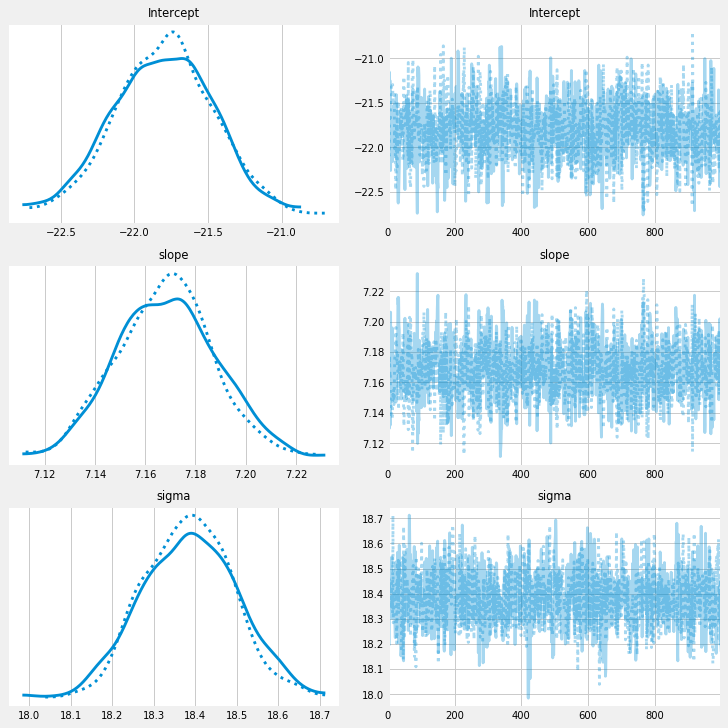

In [77]:
pm.traceplot(linear_trace, figsize = (10, 10))

d:\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F7512A1708>,
      dtype=object)

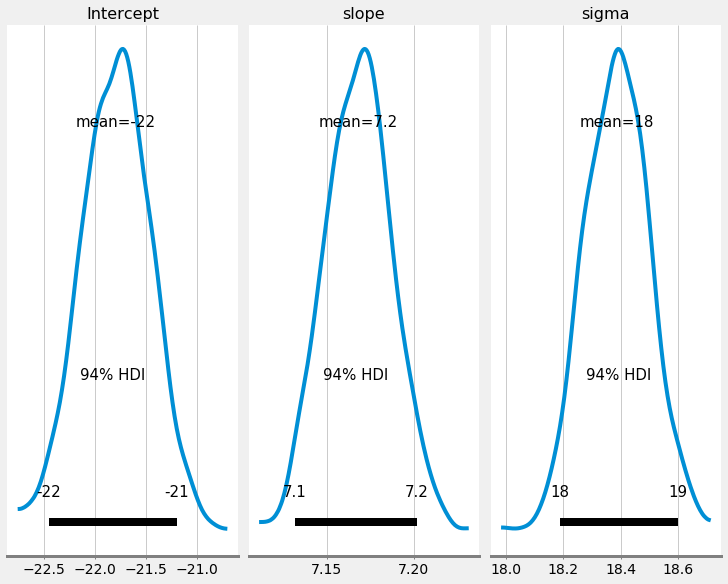

In [78]:
pm.plot_posterior(linear_trace, figsize = (10, 8))

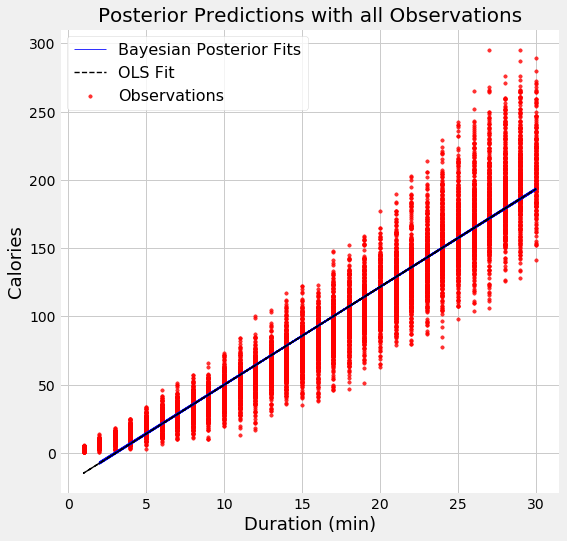

In [79]:
plt.figure(figsize = (8, 8))
pm.plot_posterior_predictive_glm(linear_trace, samples = 100, eval=np.linspace(2, 30, 100), 
              linewidth = 1, color = 'blue', alpha = 0.8, label = 'Bayesian Posterior Fits',
              lm = lambda x, sample: sample['Intercept'] + sample['slope'] * x);

plt.scatter(X['Duration'], y.values, s = 12, alpha = 0.8, c = 'red', label = 'Observations')
plt.plot(X['Duration'], ols_coefs[0] + X['Duration'] * ols_coefs[1], 'k--', label = 'OLS Fit', linewidth = 1.4)
plt.title('Posterior Predictions with all Observations', size = 20); plt.xlabel('Duration (min)', size = 18);
plt.ylabel('Calories', size = 18);
plt.legend(prop={'size': 16});

Text(0.5, 1.0, 'Posterior Prediction for 15 Minutes')

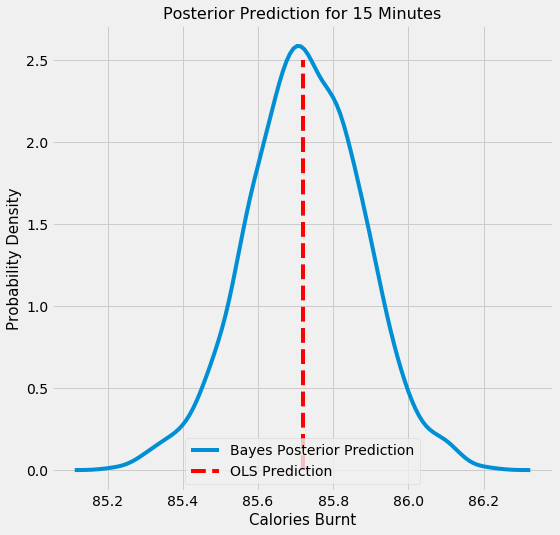

In [81]:
specific_point = 15  # this corresponds to the value in terms of minutes exercised
bayes_prediction = linear_trace['Intercept'] + linear_trace['slope'] * specific_point

# plotting the results 
plt.figure(figsize = (8, 8))
plt.style.use('fivethirtyeight')
sns.kdeplot(bayes_prediction, label = 'Bayes Posterior Prediction')
plt.vlines(x = ols_coefs[0] + ols_coefs[1] * specific_point, 
           ymin = 0, ymax = 2.5, 
           label = 'OLS Prediction',
          colors = 'red', linestyles='--')
plt.legend()
plt.xlabel('Calories Burnt', size = 15), plt.ylabel('Probability Density', size = 15)
plt.title(f'Posterior Prediction for {specific_point} Minutes', size = 16)